In [4]:
import copy
import os.path as osp

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T

from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops
import torch_geometric

from detanet_model import *

In [5]:
# https://pytorch-geometric.readthedocs.io/en/2.6.1/generated/torch_geometric.datasets.QM9.html for propertiy numbers

def preprocess_data(data):
    #Create a copy to avoid in place modification

    new_dataset = []

    for molecule in data:
        pos = molecule.pos
        z = molecule.z
        homo = molecule.y.squeeze()[2]
        lumo = molecule.y.squeeze()[3]
        gap = molecule.y.squeeze()[4]

        

        # Create the dataset entry
        data_entry = torch_geometric.data.Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            y=torch.tensor([homo, lumo], dtype=torch.float32),
            gap = gap.to(torch.float32)    
        )

        new_dataset.append(data_entry)
    return new_dataset



In [6]:
path = osp.join('..', 'data', 'QM9')
dataset = QM9(path).shuffle()
print(dataset[0])

Data(x=[16, 11], edge_index=[2, 32], edge_attr=[32, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C(=O)[C@@]1([H])C([H])([H])OC([H])([H])[C@@]1([H])C#N', name='gdb_50679', idx=[1])


In [7]:
'''We divided the dataset evenly and used 5% of the data for testing and other for training:'''
dataset = preprocess_data(dataset)
print(dataset[0])


train_datasets=[]
val_datasets=[]
for i in range(len(dataset)):
    if i%20==0:
        val_datasets.append(dataset[i])
    else:
        train_datasets.append(dataset[i])
        
len(train_datasets),len(val_datasets)

Data(y=[2], pos=[16, 3], z=[16], gap=6.117119789123535)


(124289, 6542)

In [8]:
for data in train_datasets:
    print("homo, lumo: ", data.y)
    print("gap: ", data.gap )
    print("z", data.z)
    break
    



homo, lumo:  tensor([-6.4301,  0.8055])
gap:  tensor(7.2355)
z tensor([6, 6, 6, 8, 6, 6, 8, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [9]:
'''Using torch_Geometric.dataloader.DataLoader Converts a dataset into a batch of 64 molecules of training data.'''
batches=64
trainloader=DataLoader(train_datasets,batch_size=batches,shuffle=True)
valloader=DataLoader(val_datasets,batch_size=batches,shuffle=True)

In [10]:
device = torch.device("cpu")

'''After loading the dataset, we train a model using NPA charge as an example.
 	Firstly, construct an untrained model:'''
model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=device)

model.train()

DetaNet(
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(35, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

In [11]:
from torch_geometric.nn import global_mean_pool

'''Next, define the trainer and the parameters used for training.'''
class Trainer:
    def __init__(self,model,train_loader,val_loader=None,loss_function=l2loss,device=torch.device(device),
                 optimizer='Adam_amsgrad',lr=5e-4,weight_decay=0):
        self.opt_type=optimizer
        self.device=device
        self.model=model
        self.train_data=train_loader
        self.val_data=val_loader
        self.device=device
        self.opts={'AdamW':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'AdamW_amsgrad':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adam':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'Adam_amsgrad':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adadelta':torch.optim.Adadelta(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'RMSprop':torch.optim.RMSprop(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'SGD':torch.optim.SGD(self.model.parameters(),lr=lr,weight_decay=weight_decay)
        }
        self.optimizer=self.opts[self.opt_type]
        self.loss_function=loss_function
        self.step=-1
    def train(self,num_train,targ,stop_loss=1e-8, val_per_train=50, print_per_epoch=10):
        self.model.train()
        len_train=len(self.train_data)
        for i in range(num_train):
            val_datas=iter(self.val_data)
            for j,batch in enumerate(self.train_data):
                self.step=self.step+1
                torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                out = self.model(pos=batch.pos.to(self.device), z=batch.z.to(self.device),
                                     batch=batch.batch.to(self.device))
                #print("out", out.shape)
                graph_out = global_mean_pool(out, batch.batch)  # Shape: [batch_size, d]

                # print("graph_out", graph_out.shape)

                target = batch[targ].to(self.device)

                #print("target" , target.shape)
                loss = self.loss_function(graph_out.reshape(target.shape),target)
                loss.backward()
                self.optimizer.step()
                if (self.step%val_per_train==0) and (self.val_data is not None):
                    val_batch = next(val_datas)
                    val_target=val_batch[targ].to(self.device).reshape(-1)

                    val_out = self.model(pos=val_batch.pos.to(self.device), z=val_batch.z.to(self.device),
                    batch=val_batch.batch.to(self.device))
                    # Aggregate node-level outputs to graph-level outputs
                    val_graph_out = global_mean_pool(val_out, val_batch.batch)  # Shape: [val_batch_size, d]

                    # Ensure the shapes match
                    val_loss = self.loss_function(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_mae = l1loss(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_R2 = R2(val_graph_out.reshape(val_target.shape), val_target).item()

                    if self.step % print_per_epoch==0:
                        print('Epoch[{}/{}],loss:{:.8f},val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}'
                              .format(self.step,num_train*len_train,loss.item(),val_loss,val_mae,val_R2))

                    assert (loss > stop_loss) or (val_loss > stop_loss),'Training and prediction Loss is less' \
                                                                        ' than cut-off Loss, so training stops'
                elif (self.step % print_per_epoch == 0) and (self.step%val_per_train!=0):
                    print('Epoch[{}/{}],loss:{:.8f}'.format(self.step,num_train*len_train, loss.item()))
                    
    def load_state_and_optimizer(self,state_path=None,optimizer_path=None):
        if state_path is not None:
            state_dict=torch.load(state_path)
            self.model.load_state_dict(state_dict)
        if optimizer_path is not None:
            self.optimizer=torch.load(optimizer_path)

    def save_param(self,path):
        torch.save(self.model.state_dict(),path)

    def save_model(self,path):
        torch.save(self.model, path)

    def save_opt(self,path):
        torch.save(self.optimizer,path)

    def params(self):
        return self.model.state_dict()
    

In [12]:
'''Then, modify the data type and device type'''
device=torch.device('cpu')
dtype=torch.float32
model=model.to(dtype)
model=model.to(device)

In [10]:
'''Finally, using the trainer, training 20 times from a 5e-4 learning rate'''
trainer=Trainer(model,train_loader=trainloader,val_loader=valloader,loss_function=l2loss,lr=5e-4,weight_decay=0,optimizer='AdamW')

In [11]:
trainer.train(num_train=1,targ='y')

Epoch[0/1943],loss:25.18642426,val_loss:23.28925514,val_mae:3.94110823,val_R2:-0.75185311
Epoch[10/1943],loss:2.67227650
Epoch[20/1943],loss:1.63249075
Epoch[30/1943],loss:1.31083846
Epoch[40/1943],loss:0.96627420
Epoch[50/1943],loss:0.91376466,val_loss:0.66893709,val_mae:0.63957989,val_R2:0.94415516
Epoch[60/1943],loss:0.80834812
Epoch[70/1943],loss:0.74488962
Epoch[80/1943],loss:0.67451799
Epoch[90/1943],loss:0.68465918
Epoch[100/1943],loss:0.51286316,val_loss:0.38907036,val_mae:0.50362873,val_R2:0.97013628
Epoch[110/1943],loss:0.38107473
Epoch[120/1943],loss:0.36359710
Epoch[130/1943],loss:0.41709980
Epoch[140/1943],loss:0.31956699
Epoch[150/1943],loss:0.28671083,val_loss:0.34613469,val_mae:0.44389904,val_R2:0.97305197
Epoch[160/1943],loss:0.40036455
Epoch[170/1943],loss:0.27314115
Epoch[180/1943],loss:0.25226048
Epoch[190/1943],loss:0.29224500
Epoch[200/1943],loss:0.27254385,val_loss:0.26242879,val_mae:0.39647308,val_R2:0.98021650
Epoch[210/1943],loss:0.24692650
Epoch[220/1943],los

In [12]:
torch.save(model.state_dict(),'trained_param/homo_lumo.pth')

In [15]:
eval_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)

In [13]:
import torch
from detanet_model import DetaNet

# load model

device=torch.device('cpu')

trained_model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=torch.device(device))
state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_lumo.pth")
trained_model.load_state_dict(state_dict=state_dict)

/tmp/ipykernel_39275/221179334.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_

<All keys matched successfully>

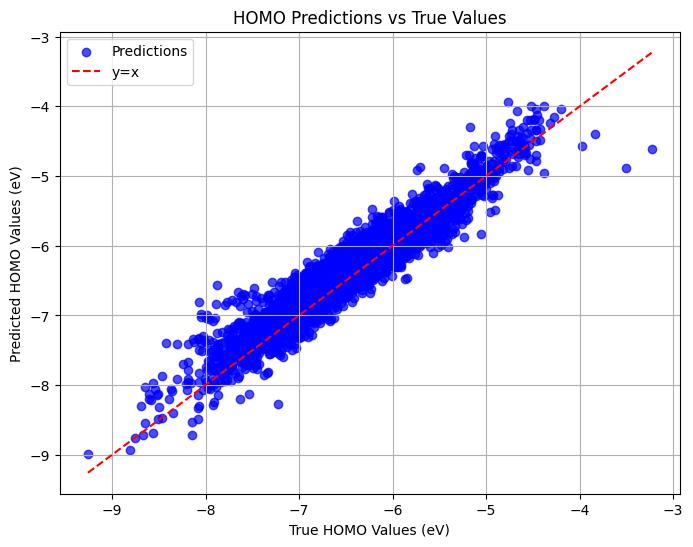

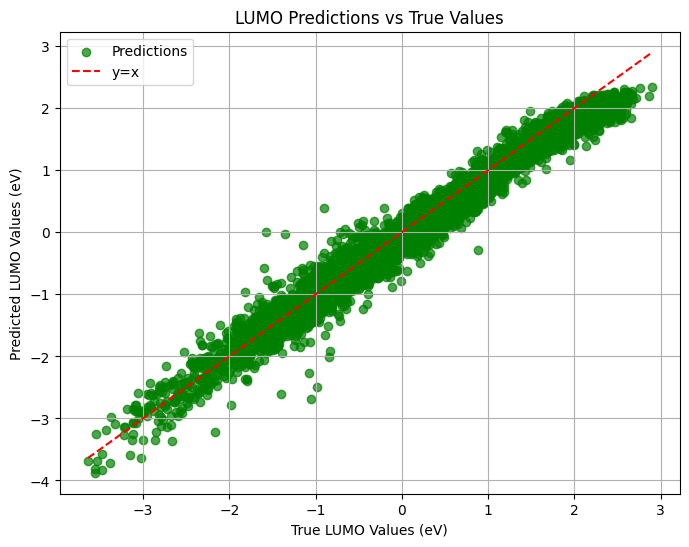

In [16]:

# Create result graphs
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import global_mean_pool

# Get predictions
predictions = []
true_values = []

for batch in eval_loader:
    true_values.append(batch.y.unsqueeze(0))  # Ensure correct shape
    with torch.no_grad():
        val_out = trained_model(pos=batch.pos.to(device), z=batch.z.to(device),
                                batch=batch.batch.to(device))
        val_graph_out = global_mean_pool(val_out, batch.batch)  # Shape: [batch_size, d]
        predictions.append(val_graph_out)

# Convert lists of tensors to a single tensor
true_values = torch.cat(true_values, dim=0).cpu()  # Now shape [num_samples, 2]
predictions = torch.cat(predictions, dim=0).cpu()  # Now shape [num_samples, 2]

# Separate HOMO and LUMO values
true_homo_values = true_values[:, 0]  # Convert to eV
true_lumo_values = true_values[:, 1]  # Convert to eV
predictions_homo_values = predictions[:, 0] 
predictions_lumo_values = predictions[:, 1] 

# 🔵 Plot HOMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_homo_values, predictions_homo_values, c='blue', alpha=0.7, label='Predictions')
plt.plot([min(true_homo_values), max(true_homo_values)], [min(true_homo_values), max(true_homo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True HOMO Values (eV)')
plt.ylabel('Predicted HOMO Values (eV)')
plt.title('HOMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("HOMO_QM9.png")

# 🟢 Plot LUMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_lumo_values, predictions_lumo_values, c='green', alpha=0.7, label='Predictions')
plt.plot([min(true_lumo_values), max(true_lumo_values)], [min(true_lumo_values), max(true_lumo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True LUMO Values (eV)')
plt.ylabel('Predicted LUMO Values (eV)')
plt.title('LUMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("LUMO_QM9.png")
